# Topic Modeling PubMed Abstracts with Latent Dirichlet Analysis
## trigrams

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# !pip install gensim==3.8.3

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [3]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [4]:
filename = '../data/pubmed_cleaned_no_outliers.csv'

In [5]:
#read in the data
df = pd.read_csv(filename).set_index('pmid')

In [6]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'date', 'citations', 'len_text',
       'len_title', 'days_live'],
      dtype='object')

In [7]:
#remove non-text, non-Y columns
df.drop(columns = ['Unnamed: 0', 'date', 'len_text', 'len_title', 'days_live'], inplace=True)

#### Combine Title & Abstract

In [8]:
df['text'] = (df['title'] + ' ' + df['text'])

In [9]:
df = df.drop(columns = 'title')

#### Remove Punctuation & Make Lowercase

In [10]:
df['text'] = df['text'].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

In [11]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [15]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [16]:
#!spacy download en_core_web_lg

In [17]:
nlp = spacy.load('en_core_web_lg')

In [18]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [19]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [20]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [21]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Trigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_trigrams)

# Create Corpus
texts = data_words_trigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [23]:
#check out the dictionary

len(id2word)

14995

### Build LDA Mallet Model

In [24]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [25]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4571456791541613


In [26]:
def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [27]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_LDAmallet_TDS10_tri.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098293 -0.147664       1        1  10.083911
1     -0.171748 -0.082476       2        1   9.285187
2     -0.083638 -0.048600       3        1  10.252845
3     -0.066566  0.329419       4        1  10.290466
4      0.010561  0.149691       5        1   9.561048
5      0.194199 -0.164431       6        1   9.960547
6     -0.120140 -0.179682       7        1  10.485176
7      0.160738  0.158895       8        1   9.805802
8      0.251538 -0.005152       9        1  10.146307
9     -0.273237 -0.010000      10        1  10.128712, topic_info=            Term         Freq        Total Category  logprob  loglift
30          data  4402.000000  4402.000000  Default  30.0000  30.0000
70       machine  4377.000000  4377.000000  Default  29.0000  29.0000
200     learning  3076.000000  3076.000000  Default  28.0000  28.0000
107        study  2539.000000  2539.000000  Default  27.0000  27.0000
354        model  2334.000000  2334.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
551        early   174.454116   393.587495  Topic10  -5.2333   1.4762
4       approach   282.551453  2219.660794  Topic10  -4.7511   0.2285
106  statistical   169.102760   418.831320  Topic10  -5.2644   1.3828
501   individual   161.610862   418.080460  Topic10  -5.3097   1.3393
60       include   174.454116  1445.109036  Topic10  -5.2333   0.1755

[823 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
397       3  0.184481   ability
397       5  0.028938   ability
397       6  0.690899   ability
397      10  0.097666   ability
2981      1  1.003486  abstract
...     ...       ...       ...
595       1  0.174368      year
595       2  0.124548      year
595       5  0.003559      year
595       8  0.071170      year
595       9  0.626300      year

[1112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#### Compute Optimal Number of Topics Based on Coherence

In [28]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)
        joblib.dump(model,f'stored_models/ldamallet_model{num_topics}_tri.pkl')
        joblib.dump(id2word,f'stored_models/id2word_dictionary_mallet{num_topics}_tri.pkl')

    return model_list, coherence_values, num_topics_list

In [30]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_trigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [31]:
#save optimal models
joblib.dump(id2word, f'stored_models/id2word_dictionary_mallet_tri.pkl')
joblib.dump(optimal_model,f'optimal_ldamallet_model_tri.pkl')

['optimal_ldamallet_model_tri.pkl']

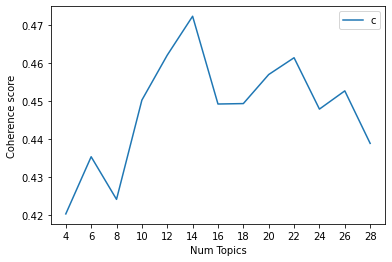

In [32]:
# Show coherence values graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks=range(4,30,2))
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence peaks at 14 topics

### Create & Visualize Model with Optimal Number of Topics

#### LDA Mallet Model: 14 Topics

In [33]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_trigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.47234944948263774


In [35]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/pubmed_optimal_LDA_mallet_model14_tri.html') 
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.195559 -0.147586       1        1  6.939013
1     -0.175041  0.234637       2        1  7.416536
2     -0.081479 -0.070090       3        1  7.251640
3      0.090392 -0.109254       4        1  7.785603
4     -0.020113  0.122397       5        1  7.243084
5     -0.151374 -0.183406       6        1  7.278295
6      0.144939 -0.132093       7        1  7.020814
7      0.101945  0.281079       8        1  7.640945
8     -0.057594  0.185447       9        1  7.118086
9      0.084775 -0.089442      10        1  6.867517
10     0.209065  0.000668      11        1  6.735103
11     0.226736 -0.048516      12        1  6.748176
12     0.043293  0.003964      13        1  6.725095
13    -0.219984 -0.047804      14        1  7.230093, topic_info=         Term         Freq        Total Category  logprob  loglift
30       data  4411.000000  4411.000000  Default  30.0000  30.0000
70    machine  4293.000000  4293.000000  Default  29.0000  29.0000
200  learning  3011.000000  3011.000000  Default  28.0000  28.0000
354     model  2358.000000  2358.000000  Default  27.0000  27.0000
67      learn  2395.000000  2395.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
46      focus   276.735904   725.926377  Topic14  -4.4347   1.6625
90    provide   340.197900  1623.054150  Topic14  -4.2283   1.0644
479     offer   170.619125   288.309605  Topic14  -4.9184   2.1023
252      make   186.224525   458.708046  Topic14  -4.8309   1.7255
70    machine   241.363641  4293.708158  Topic14  -4.5715  -0.2517

[1146 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
397       2  0.396812   ability
397       6  0.604489   ability
2981      4  0.997267  abstract
920       9  0.936767     abuse
3693     14  0.992212  academic
...     ...       ...       ...
1765      5  0.146912  workflow
595       1  0.288451      year
595      11  0.085467      year
595      14  0.626757      year
1945      6  0.969014   βstrand

[1620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

### Find the Dominant Topic in Each Document

In [36]:
pd.set_option('max_colwidth', 100)

In [37]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel, corpus=corpus, texts=data_words_trigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [38]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_trigrams)

df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#reset index to pmid numbers
df_dominant_topic.index = df.index


In [39]:
# show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,4.0,0.1583,"image, imaging, diagnosis, analysis, diagnostic, technique, detection, radiomic, cancer, feature","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,6.0,0.2666,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,6.0,0.4221,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,6.0,0.3536,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,2.0,0.1533,"data, analysis, big, information, knowledge, large, science, research, genomic, source","[future, medical, diagnostic, large, digitized, database, electronic_health_record, mandate, ame..."


#### Find the most representative document for each topic

In [56]:
doc_topics_sorteddf_mallet = pd.DataFrame()


#reset index to pmid numbers
df_topic_docs_keywords.index = df.index

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]


In [57]:
# Show representative topics and keywords
rep_docs = pd.merge(doc_topics_sorteddf_mallet,df, how='inner', left_index=True, right_index=True)


In [58]:
rep_docs.drop(columns = 'Text', inplace=True)

In [59]:
rep_docs

,Topic_Num,Topic_Perc_Contrib,Keywords,text,citations
pmid,,,,,
32635375,0.0,0.4169,"application, review, provide, technique, process, work, field, present, paper, time",when i look into your eyes: a survey on computer vision contributions for human gaze estimation ...,2
32434014,1.0,0.4660,"artificial_intelligence, clinical, ai, application, medical, practice, medicine, care, improve, ...",evolution of minimally invasive lumbar spine surgery spine surgery has evolved over centuries fr...,0
30379703,2.0,0.3913,"data, analysis, big, information, knowledge, large, science, research, genomic, source",neurotrauma as a bigdata problem purpose of review: the field of neurotrauma ...,5
26911811,3.0,0.4860,"study, review, result, literature, method, article, paper, search, conclusion, identify",extracting information from the text of electronic medical records to improve case detection: a ...,78
32410356,4.0,0.5077,"image, imaging, diagnosis, analysis, diagnostic, technique, detection, radiomic, cancer, feature",quantitative prostate mri prostate mri is reported in clinical practice using the prostate imagi...,2
31140082,5.0,0.3841,"machine, learning, learn, deep, application, ml, algorithm, apply, technique, method",applications of deep learning for the analysis of medical data over the past decade deep learnin...,8
26540053,6.0,0.5125,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...",computational prediction of rnabinding proteins and binding sites proteins and rna interaction h...,24
30982123,7.0,0.4695,"disease, patient, clinical, treatment, risk, outcome, biomarker, response, predict, identify",treatment of heart failure with preserved ejection fraction (hfpef): the phenotypeguided approac...,6
32709998,8.0,0.4429,"technology, health, system, sensor, device, healthcare, digital, detection, monitor, management",digital health technologies: opportunities and challenges in rheumatology the past decade in rhe...,3


#### Explore Relationship Between Dominant Topic and Number of Citations

In [42]:
df.head()

,text,citations
pmid,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10


In [43]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
pmid,,,,,
22627698,0,4.0,0.1583,"image, imaging, diagnosis, analysis, diagnostic, technique, detection, radiomic, cancer, feature","[extract, biological, information, computational, analysis, infrared, ftir, biospectroscopy, dat..."
22952238,1,6.0,0.2666,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[uncover, transcription, factor, module, analyse, transcriptional, regulation, critical, mediato..."
22944687,2,6.0,0.4221,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[understand, substrate, specificity, conventional, calpain, calpain, intracellular, dependent, c..."
22075226,3,6.0,0.3536,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun...","[membrane, protein, structural, bioinformatics, increase, number, recently, solve, membrane, pro..."
23012584,4,2.0,0.1533,"data, analysis, big, information, knowledge, large, science, research, genomic, source","[future, medical, diagnostic, large, digitized, database, electronic_health_record, mandate, ame..."


In [44]:
#merge on pmid index
combined_df = pd.merge(df,df_dominant_topic, how='inner', left_index=True, right_index=True)

In [45]:
combined_df.columns

Index(['text', 'citations', 'Document_No', 'Dominant_Topic',
       'Topic_Perc_Contrib', 'Keywords', 'Text'],
      dtype='object')

In [46]:
combined_df.drop(columns = ['Document_No', 'Text'], inplace=True)


In [47]:
combined_df.head()

,text,citations,Dominant_Topic,Topic_Perc_Contrib,Keywords
pmid,,,,,
22627698,extracting biological information with computational analysis of fouriertransform infrared (ftir...,35,4.0,0.1583,"image, imaging, diagnosis, analysis, diagnostic, technique, detection, radiomic, cancer, feature"
22952238,uncovering transcription factor modules using one and threedimensional analyses transcriptional ...,4,6.0,0.2666,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun..."
22944687,understanding the substrate specificity of conventional calpains calpains are intracellular ca(2...,19,6.0,0.4221,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun..."
22075226,membrane protein structural bioinformatics despite the increasing number of recently solved memb...,12,6.0,0.3536,"prediction, method, computational, protein, predict, tool, interaction, approach, structure, fun..."
23012584,the future of medical diagnostics: large digitized databases the electronic health record mandat...,10,2.0,0.1533,"data, analysis, big, information, knowledge, large, science, research, genomic, source"


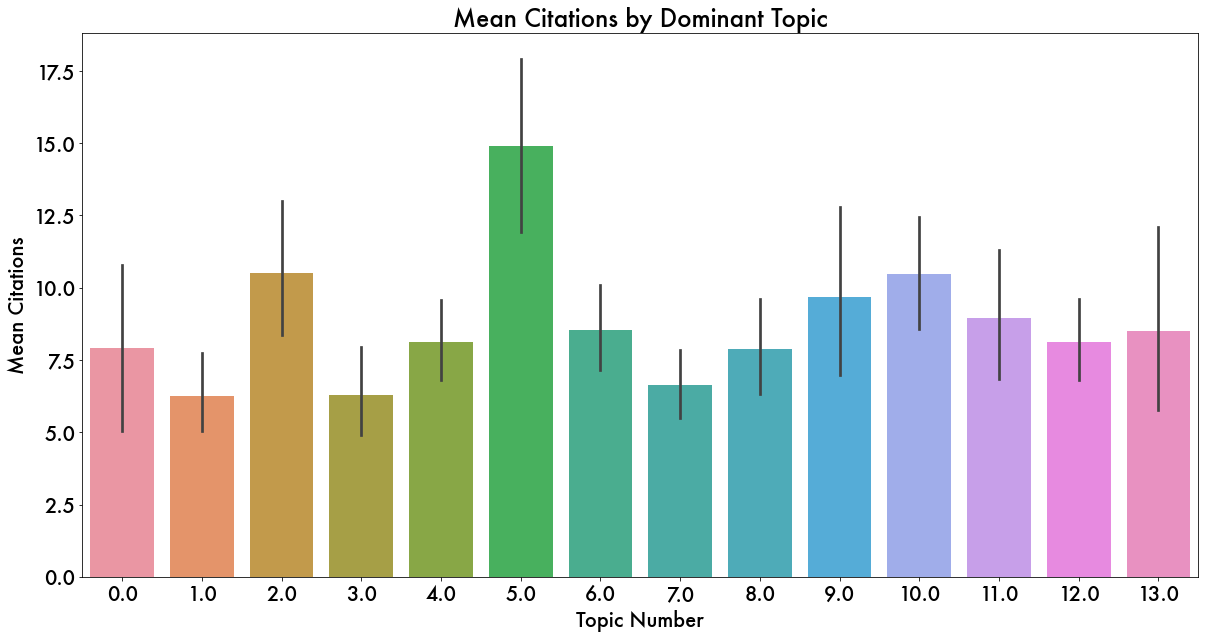

In [68]:
plt.figure(figsize = (20, 10));
sns.barplot(data=combined_df, x='Dominant_Topic', y='citations');
figurefont = {'fontname' : 'Futura'};
plt.title('Mean Citations by Dominant Topic', fontsize = 24,**figurefont );
plt.xticks(**figurefont, fontsize = 20);
plt.yticks(**figurefont, fontsize = 20);
plt.xlabel('Topic Number',**figurefont, fontsize = 20);
plt.ylabel('Mean Citations',**figurefont, fontsize = 20);
plt.savefig('../figures/pubmed_mean_citations_bigram_model.jpg',  bbox_inches = "tight")

#### Model Citations by Topic

In [69]:
#the topics are not ordinal, so I will convert them to strings

combined_df['Dominant_Topic'] = combined_df['Dominant_Topic'].apply(lambda x: str(x).strip('.0').zfill(2))


In [70]:
df = pd.get_dummies(combined_df,columns=['Dominant_Topic'], drop_first=True)

In [71]:
df.columns

Index(['text', 'citations', 'Topic_Perc_Contrib', 'Keywords',
       'Dominant_Topic_01', 'Dominant_Topic_02', 'Dominant_Topic_03',
       'Dominant_Topic_04', 'Dominant_Topic_05', 'Dominant_Topic_06',
       'Dominant_Topic_07', 'Dominant_Topic_08', 'Dominant_Topic_09',
       'Dominant_Topic_11', 'Dominant_Topic_12', 'Dominant_Topic_13'],
      dtype='object')

In [72]:
import statsmodels.api as sm

In [73]:
X = df.drop(columns=['text','citations','Topic_Perc_Contrib','Keywords'])
X = sm.add_constant(X, prepend=True)
y = df['citations']

In [74]:
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              citations   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.527
Date:                Mon, 10 May 2021   Prob (F-statistic):           2.85e-07
Time:                        22:08:09   Log-Likelihood:                -11407.
No. Observations:                2809   AIC:                         2.284e+04
Df Residuals:                    2796   BIC:                         2.292e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.9024      1.554      5.086      0.000       4.856      10.949
Dominant_Topic_01     0.2410      1.674      0.144      0.886      -3.042       3.524
Dominant_Topic_02     2.6168      1.835      1.426      0.154      -0.981       6.214
Dominant_Topic_03    -1.6176      1.888     -0.857      0.392      -5.320       2.085
Dominant_Topic_04     0.2158      1.746      0.124      0.902      -3.207       3.639
Dominant_Topic_05     6.9888      1.855      3.768      0.000       3.352      10.626
Dominant_Topic_06     0.6312      1.802      0.350      0.726      -2.902       4.164
Dominant_Topic_07    -1.2677      1.822     -0.696      0.487      -4.840       2.304
Dominant_Topic_08    -0.0401      1.823     -0.022      0.982      -3.614       3.534
Dominant_Topic_09     1.7785      1.905      0.934      0.351      -1.957       5.514
Dominant_Topic_11     1.0424      1.944      0.536      0.592      -2.770       4.855
Dominant_Topic_12     0.2321      1.770      0.131      0.896      -3.239       3.704
Dominant_Topic_13     0.6111      2.256      0.271      0.787      -3.813       5.035
==============================================================================
Omnibus:                     1899.679   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22317.178
Skew:                           3.161   Prob(JB):                         0.00
Kurtosis:                      15.276   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Topic 5